# Project Argus

This part of the project is focused on the use of machine learning for the selection of the study machines needed by the analyst. 

In [1]:
# Firt we import some libraries. 

from Scripts.datosadash import datosADASH
import pandas as pd
import itertools
import datetime
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
# To get all files extracted from vibration analysis software we have created the module "datosADASH".
# The software export a csv file for every measurement. 

# Before importation we must set the path
folder = datosADASH('Data/Export')

In [3]:
# Next we get the name of files, machines and points with methods of "datosADASH" module.
# getmachines return 

machines = folder.getmachines()
points = folder.getpoints()
files = folder.getfiles()

In [4]:
print("\nDATA SUMMARY")
print("===============================")
print("We have a total of {} machines".format(len(machines)))
print("We have a total of {} points".format(sum([len(points[x]) for x in points])))
print("We have a total of {} files".format(len(files)))
print("===============================")



DATA SUMMARY
We have a total of 192 machines
We have a total of 1920 points
We have a total of 60021 files


## Data import and cleaning

Now we have a list of machines, points and files we are going to import and clean. We are going to iterate in the dynamic mesurements to obtein revelant information. We have a total of 48510 files, so we may need to optimize data extraction. In our case we will use a Multiprocess method to reduce import time.

In [5]:
# Now we iterate for every file and get the data we need. Due the structure of .csv files
# we get raw data first and the date from the first line fo the file.

'''from Scripts.waveform import Waveform, Raw_Waveform_Date
from Scripts.spectrum import Spectrum


waveform_parameters = []'''

df_mms_params = pd.DataFrame(columns=['machine','point','time','max_mms','rms_mms'])
df_acc_params = pd.DataFrame(columns=['machine','point','time','max_acc',
                                      'med_acc','rms_acc', 'kur_acc', 'cf_acc'])
df_dem_params = pd.DataFrame(columns=['machine','point','time','max_dem','rms_dem'])
df_spec_acc_params = pd.DataFrame(columns=['machine','point','time','num_peaks',
                                          'a_range','b_range', 'c_range','d_range',
                                          'e_range','f_range','g_range','h_range',
                                          'i_range','j_range'])

df_mms_params.to_csv('Data/mms_params.csv', index=False)
df_acc_params.to_csv('Data/acc_params.csv', index=False)
df_dem_params.to_csv('Data/dem_params.csv', index=False)
df_spec_acc_params.to_csv('Data/df_spec_acc_params.csv', index=False)

# To identify the type of measurement we must copy
# the point definition in ADASH Software
vel_time_text = "Velocidad - Forma de onda"
acc_time_text = "Aceleracion - Forma de onda"
demod_time_text = "Demodulacion - Forma de onda"
acc_spec_text = "Aceleracion - Espectro"

In [6]:
# Secuencual solution. With this solution Wall Time is about
# 26 minutes. Too much time for a coffe, we just left the
# the code for informative propurse

"""
%%time



for machine, points_iter in points.items():
    filteredmachines = list(filter(lambda x: machine in x, files))
    for iteration, point in enumerate(points_iter):
        # Get the files for every point        
        filteredpoints = list(filter(lambda x: point in x, filteredmachines))
        filteredcsv = list(filter(lambda x:".csv" in x, filteredpoints))
        
        # Get files by type of measurement
        veltime = list(filter(lambda x:vel_time_text in x, filteredcsv))
        acctime = list(filter(lambda x:acc_time_text in x, filteredcsv))
        demodtime = list(filter(lambda x:demod_time_text in x, filteredcsv))
        accspec = list(filter(lambda x:acc_spec_text in x, filteredcsv))
        
        
        # Get mms parameters for analysis
        for filetime in veltime:
            
            # We use Raw_Waveform_Date model to get
            # column with waveform data and date
            # measurement
            raw_data = Raw_Waveform_Date(filetime)
            column_vel = raw_data.get_raw_data()
            date_df_time = raw_data.get_datetime()         

            # Now we use get_mm_params method to get useful 
            # features of raw signal
            calculated_params = Waveform(column_vel).get_mms_params()
            
            # Creation of a row to be append in the dataframe
            time_mms_row = {'machine':machine, 'point':point, 'max_mms':calculated_params[0],
                       'rms_mms':calculated_params[1], 'time':date_df_time}
            
            
            df_mms_params = df_mms_params.append(time_mms_row, ignore_index=True)
        
        
        
        # Get acceleration params. Same procedure as mms, but
        # we use get_acc_params method wich return parameters
        # associated with acceleration
        for filetime in acctime:
            
            raw_data = Raw_Waveform_Date(filetime)
            column_vel = raw_data.get_raw_data()
            date_df_time = raw_data.get_datetime()
            
            calculated_params = Waveform(column_vel).get_acc_params()
            
            time_acc_rows = {'machine':machine, 'point':point, 'max_acc':calculated_params[0],
                       'med_acc':calculated_params[1], 'rms_acc':calculated_params[2],
                        'kur_acc':calculated_params[3], 'cf_acc':calculated_params[4],
                        'time':date_df_time}
            
            df_acc_params = df_acc_params.append(time_acc_rows, ignore_index=True)
            
            
        # Get demomd params. Mostly the same than mm/s
        # params                
        for filetime in demodtime:
            
            raw_data = Raw_Waveform_Date(filetime)
            column_vel = raw_data.get_raw_data()
            date_df_time = raw_data.get_datetime()
            
            calculated_params = Waveform(column_vel).get_demod_params()
            
            time_demod_rows = {'machine':machine, 'point':point, 'max_dem':calculated_params[0],
                               'rms_dem':calculated_params[1],  'time':date_df_time}
            
            df_dem_params = df_dem_params.append(time_demod_rows, ignore_index=True)
            
            

       
        # Get spectrum params. In spectrum is important
        # peaks that are excitated. The number of peaks is
        # associated with damage severity.
        for filespec in accspec:
            spectrum_data = Spectrum(filespec) 
            date_df_spec = spectrum_data.get_datetime()
            peaks, calculated_params, a_range, b_range, c_range, d_range, e_range, f_range, \
            g_range, h_range, i_range, j_range = spectrum_data.get_spec_params()
            
            spec_acc_row = {'machine':machine, 'point':point,
                            'num_peaks': float(len(peaks)), 'peaks':peaks,
                            'time':date_df_spec, 'a_range':a_range, 'b_range':b_range, 
                            'c_range':c_range, 'd_range':d_range, 'e_range':e_range,
                            'f_range':f_range, 'g_range':g_range, 'h_range':h_range,
                            'i_range':i_range, 'j_range':j_range}            
            
            
            df_spec_acc_params = df_spec_acc_params.append(spec_acc_row, ignore_index=True)
"""
print("")

In [6]:
%%time
# MultiProcess aproach. Using multiprocessing library we can create multiple
# processes to reduce time due to data reading.

from multiprocessing import Process
from Scripts.get_values import get_values
import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
import time

processes = []       


machines_split = np.array_split(machines, 5)
len(machines_split)

if __name__ == '__main__':

    for index in range(len(machines_split)):
    # We start one thread per file present.
        print("Starting index {} - Number of machines {}".format(index, len(machines_split[index])))
        logging.info("[P{}]\tStartin index".format(index))
        process = Process(target=get_values, args=[index, machines_split[index], points,
                                                   files, df_mms_params, df_acc_params,
                                                   df_dem_params, df_spec_acc_params])

        processes.append(process)
        process.start()

    # We now pause execution on the main thread by 'joining' all of our started threads.
    # This ensures that each has finished processing.
    for process in processes:
        process.join()

Starting index 0 - Number of machines 39
Starting index 1 - Number of machines 39
Starting index 2 - Number of machines 38
Starting index 3 - Number of machines 38
Starting index 4 - Number of machines 38
Ended with machine S5-70-M1 in process 2
Ended with machine S4-61-M1 in process 1
Ended with machine S5-66-M2 in process 2
Ended with machine S3-M06 in process 0
Ended with machine S1-M11 in process 3
Ended with machine S2-M42 in process 4
Ended with machine S4-71-M2 in process 1
Ended with machine S5-74-M1 in process 2
Ended with machine S3-M39 in process 0
Ended with machine S2-M11 in process 4
Ended with machine S4-76-M2 in process 1
Ended with machine S1-M24 in process 3
Ended with machine S5-70-M2 in process 2
Ended with machine S4-62-M1 in process 1
Ended with machine S2-M03 in process 4
Ended with machine S5-60-M1 in process 2
Ended with machine S3-M23 in process 0
Ended with machine S1-M01 in process 3
Ended with machine S4-66-M1 in process 1
Ended with machine S5-74-M2 in pro

In [7]:
#Now we load the created csv from files

df_mms_params = pd.read_csv('Data/mms_params.csv')
df_acc_params = pd.read_csv('Data/acc_params.csv')
df_dem_params = pd.read_csv('Data/dem_params.csv')
df_spec_acc_params = pd.read_csv('Data/df_spec_acc_params.csv')

In [8]:
# Now we check all dataframes returns the same
# numbers of machines

print("MACHINES IN FILES")
print("==================================")
print("File with mms params: {} machines".format(len(df_mms_params.machine.unique())))
print("File with acc params: {} machines".format(len(df_acc_params.machine.unique())))
print("File with demod params: {} machines".format(len(df_dem_params.machine.unique())))
print("File with acc spectrum params: {} machines".format(len(df_spec_acc_params.machine.unique())))
print("==================================")

MACHINES IN FILES
File with mms params: 192 machines
File with acc params: 192 machines
File with demod params: 192 machines
File with acc spectrum params: 192 machines


In [9]:
# If something goes wrong we only keep rows where machine
# column value is in the list of machines

df_dem_params = df_dem_params[df_dem_params['machine'].isin(machines)]
df_spec_acc_params = df_spec_acc_params[df_spec_acc_params['machine'].isin(machines)]
df_mms_params = df_mms_params[df_mms_params['machine'].isin(machines)]
df_acc_params = df_acc_params[df_acc_params['machine'].isin(machines)]

In [10]:
# We need sort the dataframes by time and set it as index

def sorted_index_by_time(df):
    """Function for sorting values
    by time and set it to index"""
    df = df.sort_values(['time'])
    df['time'] = pd.to_datetime(df['time'])
    return df

df_mms_params_sorted = sorted_index_by_time(df_mms_params)
df_acc_params_sorted = sorted_index_by_time(df_acc_params)
df_dem_params_sorted = sorted_index_by_time(df_dem_params)
df_spec_acc_params_sorted = sorted_index_by_time(df_spec_acc_params)

In [11]:
# In this step we merge dataframes on time using merge_asof because maybe
# timestamp does not fit perfectly, so merge_asof search for the
# nearest timestamp

merged = pd.merge_asof(df_mms_params_sorted, df_acc_params_sorted, on="time", by=['machine', 'point'])
merged = pd.merge_asof(merged, df_spec_acc_params_sorted, on="time", by=['machine', 'point'])
merged = pd.merge_asof(merged, df_dem_params_sorted, on="time", by=['machine', 'point'])

# After that we set all frequency range as float

for col in ['c_range', 'd_range', 'e_range',
      'e_range', 'g_range', 'h_range',
      'i_range', 'i_range']:
    merged[col] = merged[col].astype('float64')

In [13]:
# Now the dataframe has the columns:    
merged.columns
merged[merged['machine']=='S3-M36'].head(20)

,machine,point,time,max_mms,rms_mms,max_acc,med_acc,rms_acc,kur_acc,cf_acc,num_peaks,a_range,b_range,c_range,d_range,e_range,f_range,g_range,h_range,i_range,j_range,max_dem,rms_dem
1015,S3-M36,M-LOA-H,2019-07-16 12:04:50.126,8.0483,3.985185,0.44967,0.336766,0.137950,0.507294,3.259649,1.0,0.10510,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.26710,0.113708
1018,S3-M36,M-LOA-V,2019-07-16 12:05:02.865,5.6421,2.224712,0.45584,0.302782,0.114470,0.084484,3.982169,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.30973,0.136540
1019,S3-M36,M-LA-H,2019-07-16 12:05:14.194,5.1576,1.735983,0.45779,0.296647,0.110352,0.018419,4.148452,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.32742,0.148582
1021,S3-M36,M-LA-V,2019-07-16 12:05:23.856,6.6116,2.731961,0.47563,0.299358,0.110941,0.149394,4.287242,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.33230,0.128763
1023,S3-M36,M-LA-A,2019-07-16 12:05:33.679,8.1404,3.691353,0.41241,0.312657,0.117926,0.573636,3.497183,1.0,0.09250,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.20847,0.089804
1025,S3-M36,V-LA-H,2019-07-16 12:05:46.506,13.1000,5.237150,3.49120,0.821845,0.851471,0.139441,4.100199,11.0,0.11577,0.00000,0.00000,0.09040,0.00000,0.16220,0.49440,0.11107,0.23915,0.08328,3.57200,1.668295
1026,S3-M36,V-LA-V,2019-07-16 12:05:58.197,12.0170,4.997745,3.83390,0.882699,0.979333,0.039966,3.914809,17.0,0.11792,0.22107,0.00000,0.30150,0.27714,0.09052,0.31436,0.09161,0.29574,0.32725,3.85520,1.888714
1028,S3-M36,V-LOA-H,2019-07-16 12:06:10.916,4.7861,1.951917,4.31640,0.890284,0.997516,0.117329,4.327150,14.0,0.00000,0.00000,0.09972,0.18625,0.33449,0.43458,0.70792,0.08601,0.28435,0.00000,4.29890,1.919117
1030,S3-M36,V-LOA-V,2019-07-16 12:06:21.904,6.3822,2.229893,4.39970,0.824573,0.857259,0.147192,5.132289,14.0,0.08964,0.00000,0.00000,0.10991,0.11769,0.00000,0.20254,0.11134,0.49045,0.11519,3.92520,1.718716
1032,S3-M36,V-LOA-A,2019-07-16 12:06:33.680,6.8549,2.848701,2.17770,0.660751,0.547508,0.012262,3.977474,3.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.12158,0.25689,0.00000,0.00000,0.00000,2.31160,0.996690


In [13]:
# And the dataframe has this data:

merged_2021 = merged[merged.time.dt.year == 2021]


In [15]:
merged_2021.groupby('machine').count()

,point,time,max_mms,rms_mms,max_acc,med_acc,rms_acc,kur_acc,cf_acc,num_peaks,a_range,b_range,c_range,d_range,e_range,f_range,g_range,h_range,i_range,j_range,max_dem,rms_dem
machine,,,,,,,,,,,,,,,,,,,,,,
S1-M01,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
S1-M02,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
S1-M03,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
S1-M05,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
S1-M06,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S6-77-M2,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
S6-78-M1,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
S6-78-M2,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10


In [16]:
merged_2021.to_csv('Data/diagnosis_2021.csv')

## Labeling

For get labels we use the diagnostic made by the analyst. We have exported data from sql database were reports are stored to csv file. To read csv files, due to names of machines in SQL database are different than names in vibration software DB, we need to load a csv with the relation between these names. After that we merge the diagnostics with the previous dataframe.

We have two DB because in 2020 we upgraded the software where reports are generated and DB was also modified.

In [25]:
# Data from legacy DB.
diagnosis = pd.read_csv('Data/diagnosticos_secaderos.csv', sep=",").sort_values('Fecha')
diagnosis.Fecha = pd.to_datetime(diagnosis.Fecha)
diagnosis = diagnosis.rename(columns={'Fecha':'time',
                                          'fnStripTags(HTML_UnEncode(an.Texto))':'diagnostico'})



# Data from current DB
diagnosis_new = pd.read_csv('Data/secaderos_new_2.csv', sep=",")
diagnosis_new[' Fecha']= pd.to_datetime(diagnosis_new[' Fecha'])
diagnosis_new = diagnosis_new.rename(columns={'Activo':'Nombre',
                                                  'Estado':'Id_Estado_Activo',
                                                  'Diagnóstico':'diagnostico',
                                                  ' Fecha':'time'})
diagnosis_new = diagnosis_new.drop(columns=['Recomendaciones'])

# In this exportation status of machines are labeled as "BUENO", "SEGUIMIENTO",
# and "ACTUACION". In order to fit with previous dataframe we need to map
# this values with a Id code
estados = {'BUENO':1,
          'SEGUIMIENTO':2,
          'ACTUACION':3}
diagnosis_new.Id_Estado_Activo = diagnosis_new.Id_Estado_Activo.map(estados)


# Now we can append the dataframes

diag_total = diagnosis.append(diagnosis_new, sort=False)


# In this step we load the csv to help us to relate names from SQL DB 
# and Vibration Software
usecols = ['Equipo_adash', 'Equipo_home']
names = pd.read_csv('Data/nombres_filt.csv', sep=',',  encoding = "ISO-8859-1", usecols=usecols)
names = names.rename(columns={"Equipo_adash":"machine", "Equipo_home":"Nombre"})



# Finally we merge the dataframes, taking care for differences
# in machine names between databases and also using merge_asof

diagnosis_mer = diag_total.merge(names, how="outer", on="Nombre")
dict_machines = {'S1-M1':'S1-M01', 'S1-M2':'S1-M02',
                'S1-M3':'S1-M03', 'S1-M5':'S1-M05',
                'S1-M6':'S1-M06', 'S1-M8':'S1-M08',
                'S1-M9':'S1-M09', 'S2-M1':'S2-M01',
                'S2-M2':'S2-M02', 'S2-M3':'S2-M03',
                'S2-M5':'S2-M05', 'S2-M6':'S2-M06',
                'S2-M8':'S2-M08', 'S2-M9':'S2-M09',
                'S3-M1':'S3-M01', 'S3-M2':'S3-M02',
                'S3-M3':'S3-M03', 'S3-M5':'S3-M05',
                'S3-M6':'S3-M06', 'S3-M8':'S3-M08',
                'S3-M9':'S3-M09'}
diagnosis_mer.machine = diagnosis_mer.machine.replace(dict_machines)
diagnosis_mer = diagnosis_mer.dropna()
diagnosis_mer = diagnosis_mer.sort_values('time')
diagnosis = pd.merge_asof(merged, diagnosis_mer, on="time", by=['machine'],
                  tolerance=pd.Timedelta('40 days'), direction='nearest')

diagnosis = diagnosis.dropna()

  machine             Nombre
0  S1-M02  S1-Ventilador M02
1  S1-M02   S1-Ventilador M2
2  S1-M03  S1-Ventilador M03
3  S1-M03   S1-Ventilador M3
4  S1-M05  S1-Ventilador M05


In [26]:
# Now we have a dataframe with all measurments with the
# features we considered important and the diagnosis 
# set by the analyst in the column "Id_Estado_Activo".
# We hace three labeles now:
# 1 - Good
# 2 - Warning
# 3 - Alarm


diagnosis.head()

,machine,point,time,max_mms,rms_mms,max_acc,med_acc,rms_acc,kur_acc,cf_acc,num_peaks,a_range,b_range,c_range,d_range,e_range,f_range,g_range,h_range,i_range,j_range,max_dem,rms_dem,Nombre,diagnostico,Id_Estado_Activo
1,S3-M38,M-LOA-H,2019-06-18 12:38:26.205,9.2617,4.066749,0.46940,0.347729,0.148627,0.388228,3.158231,1.0,0.09968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31838,0.130597,S3-Ventilador M38,Motor: Activo en buen estado.\n Ventilador: S...,2.0
3,S3-M38,M-LOA-V,2019-06-18 12:38:41.249,6.4828,2.278911,0.43131,0.349279,0.147235,0.579381,2.929393,1.0,0.11478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.22062,0.103748,S3-Ventilador M38,Motor: Activo en buen estado.\n Ventilador: S...,2.0
4,S3-M38,M-LA-H,2019-06-18 12:38:57.866,7.4407,2.977928,0.64757,0.334221,0.141516,0.324311,4.575943,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53557,0.168171,S3-Ventilador M38,Motor: Activo en buen estado.\n Ventilador: S...,2.0
7,S3-M38,M-LA-V,2019-06-18 12:39:08.660,6.9886,2.452952,0.72522,0.339139,0.146303,0.600235,4.956958,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.55888,0.169940,S3-Ventilador M38,Motor: Activo en buen estado.\n Ventilador: S...,2.0
8,S3-M38,M-LA-A,2019-06-18 12:39:20.397,7.3701,3.351391,0.48182,0.343762,0.145565,0.395430,3.309999,2.0,0.17693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.24158,0.095285,S3-Ventilador M38,Motor: Activo en buen estado.\n Ventilador: S...,2.0


The health of the equipment (motor+fan) is saved in a column in the database, and the detailed diganosis is saved in plain text just like that:

<table style="width:80%">
  <tr>
    <th>Diagnosis</th>
    <th>Status</th>
  </tr>
  <tr>
    <td>Motor: Activo en buen estado. <br>
        Ventilador: Activo en buen estado.
      </td>
    <td>Good</td>
  </tr>
  <tr>
    <td>Motor: Síntomas de degradación de 
        rodamientos. Seguimiento.<br>
        Ventilador: Activo en buen estado.
      </td>
    <td>Seguimiento</td>
  </tr>
</table>

In the second row Motor is diagnosed as 2 (Warning) and equipment status has labeled also has Warning, but the Fan status is ok. 
We must correct that to prevent an element in good health from being labeled as "warning" or "alert".

In [27]:
# We create a function to modify the label.

def texto_diagnostico(row):
    if '\n' in row['diagnostico']:
        texto_separado = row['diagnostico'].split('\n')
    else:
        texto_separado = row['diagnostico'].split('. ')
    buen = "buen"
    ventilador ="Ventilador"
    motor = "Motor"
    conjunto = "Conjunto"
    if len(texto_separado) > 1:
        if buen in texto_separado[0] and row['Id_Estado_Activo'] > 1 and row['point'].strip().startswith("M"):            
            valor_estado = 1
        if buen in texto_separado[1] and row['Id_Estado_Activo'] > 1 and row['point'].strip().startswith("V"):            
            valor_estado = 1
        else:
            valor_estado = row['Id_Estado_Activo']
    if len(texto_separado) == 1:        
        if ventilador in texto_separado[0] and row['point'].strip().startswith("V"):              
            valor_estado = row['Id_Estado_Activo']
        if motor in texto_separado[0] and row['point'].strip().startswith("M"):            
            valor_estado = row['Id_Estado_Activo']
        if conjunto in texto_separado[0]:
            valor_estado = row['Id_Estado_Activo']
        else:
            valor_estado = 1
    if row['max_mms'] > 10:
        valor_estado = 2
    if row['max_acc'] > 5:
        valor_estado = 2
    return valor_estado

In [28]:
# Now we use the function with apply method

diagnosis['Id_Estado_Activo_fixed'] = diagnosis.apply(lambda row: texto_diagnostico(row), axis=1)

# Data Checkpoint

In this point we create a copy of the main dataframe for avoid time consuming operations if something goes wrong in the future

In [46]:
diagnosis_cop = diagnosis.copy()

In [47]:
diagnosis_cop[['Nombre', 'diagnostico', 'Id_Estado_Activo_fixed', 'time', 'max_mms',
       'machine']].to_csv('diagnosis.csv')

In [48]:
# Lets take a look to the dataframe with the new column "Id_Estado_Activo_fixed" for a machine

diagnosis_cop[diagnosis_cop['machine']=='S5-61-M1'][['point','diagnostico','Id_Estado_Activo','Id_Estado_Activo_fixed']]

,point,diagnostico,Id_Estado_Activo,Id_Estado_Activo_fixed
213,M-LOA-H,Motor: Activo en buen estado. \n Ventilador: ...,1.0,2.0
214,M-LOA-V,Motor: Activo en buen estado. \n Ventilador: ...,1.0,2.0
215,M-LA-H,Motor: Activo en buen estado. \n Ventilador: ...,1.0,1.0
216,M-LA-V,Motor: Activo en buen estado. \n Ventilador: ...,1.0,2.0
217,M-LA-A,Motor: Activo en buen estado. \n Ventilador: ...,1.0,1.0
218,V-LA-H,Motor: Activo en buen estado. \n Ventilador: ...,1.0,1.0
219,V-LA-V,Motor: Activo en buen estado. \n Ventilador: ...,1.0,2.0
220,V-LOA-H,Motor: Activo en buen estado. \n Ventilador: ...,1.0,1.0
221,V-LOA-V,Motor: Activo en buen estado. \n Ventilador: ...,1.0,2.0
222,V-LOA-A,Motor: Activo en buen estado. \n Ventilador: ...,1.0,1.0


# Data Exploration

Now we explore data to identify data outliers or relations

In [49]:
diagnosis_cop.columns

Index(['machine', 'point', 'time', 'max_mms', 'rms_mms', 'max_acc', 'med_acc',
       'rms_acc', 'kur_acc', 'cf_acc', 'num_peaks', 'a_range', 'b_range',
       'c_range', 'd_range', 'e_range', 'f_range', 'g_range', 'h_range',
       'i_range', 'j_range', 'max_dem', 'rms_dem', 'Nombre', 'diagnostico',
       'Id_Estado_Activo', 'Id_Estado_Activo_fixed'],
      dtype='object')

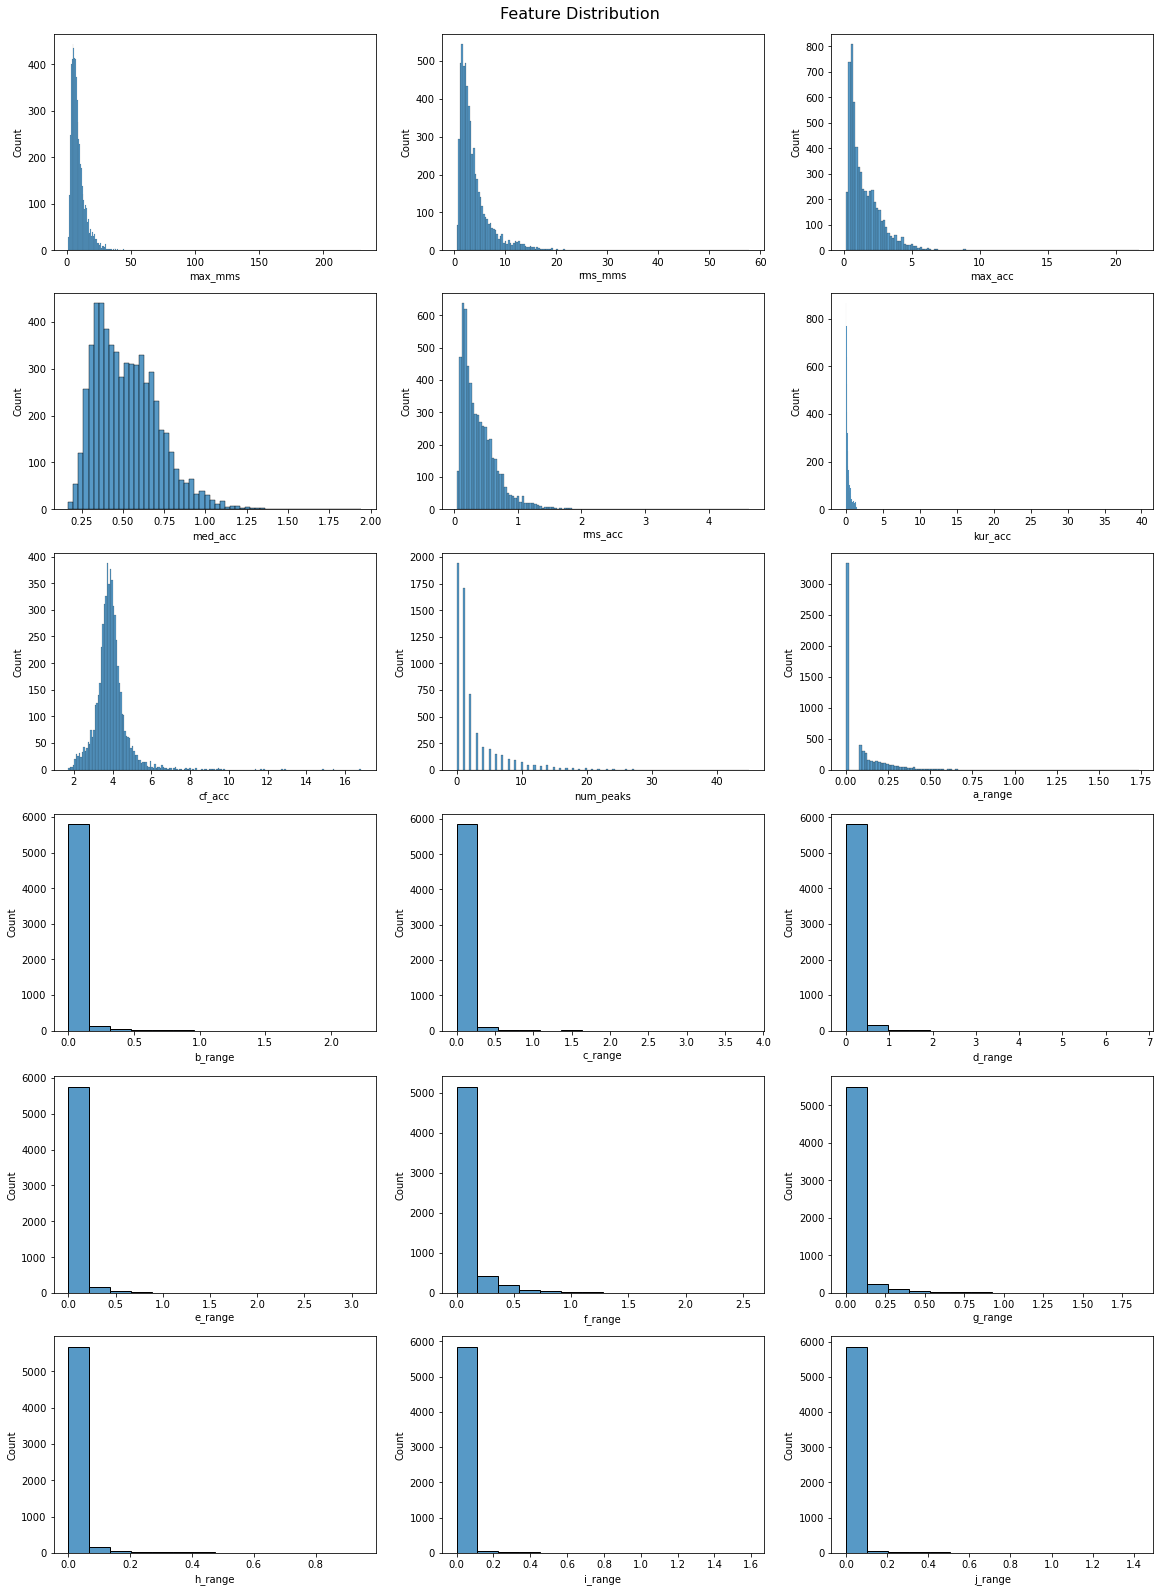

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt



fig, axs = plt.subplots(ncols=3, nrows=6, figsize=(16,22), constrained_layout=True)

columns = ['max_mms', 'rms_mms', 'max_acc', 'med_acc',
       'rms_acc', 'kur_acc', 'cf_acc', 'num_peaks','a_range', 'b_range',
       'c_range','d_range', 'e_range', 'f_range', 'g_range', 'h_range',
       'i_range', 'j_range', 'max_dem', 'rms_dem',]

fig.suptitle('Feature Distribution', fontsize=16)
for index, value in enumerate(columns):
    if index < 3:
        sns.histplot(data=diagnosis_cop, x=value, ax=axs[0][index])
    if index >= 3 and index < 6 :
        sns.histplot(data=diagnosis_cop, x=value, ax=axs[1][index -  3])
    if index >=6 and index < 9:
        sns.histplot(data=diagnosis_cop, x=value, ax=axs[2][index -  6])
    if index >=9 and index < 12:
        sns.histplot(data=diagnosis_cop, x=value, ax=axs[3][index -  9])
    if index >=12 and index < 15:
        sns.histplot(data=diagnosis_cop, x=value, ax=axs[4][index -  12])
    if index >=15 and index < 18:
        sns.histplot(data=diagnosis_cop, x=value, ax=axs[5][index -  15])
plt.show()

In [51]:
# We can check that some of the features have outlieres, lets clean them:

diagnosis_cop = diagnosis_cop[diagnosis_cop['max_mms'] < 50]
diagnosis_cop = diagnosis_cop[diagnosis_cop['rms_mms'] < 20]

<AxesSubplot:>

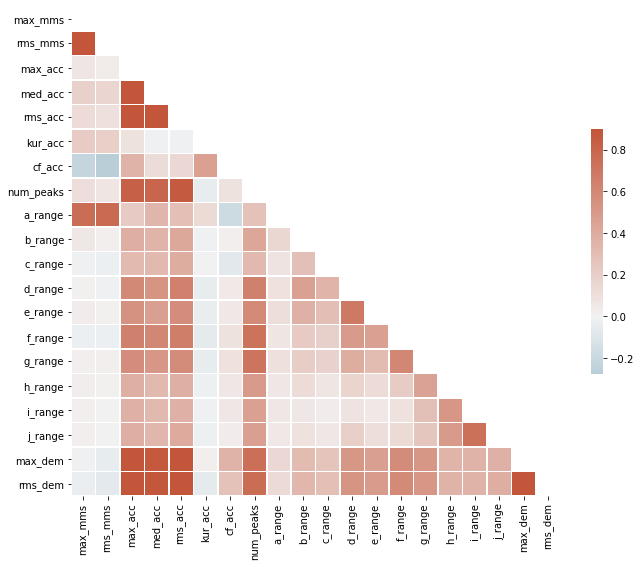

In [52]:
# Now we must check the correlation between variables

columns = ['max_mms', 'rms_mms', 'max_acc', 'med_acc',
       'rms_acc', 'kur_acc', 'cf_acc', 'num_peaks','a_range', 'b_range',
       'c_range','d_range', 'e_range', 'f_range', 'g_range', 'h_range',
       'i_range', 'j_range', 'max_dem', 'rms_dem',]


# Compute the correlation matrix
corr = diagnosis_cop[columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

As can be seen, some of the features are correlated, especially those associated with the same type of measurement (rms_mms with max_mms). This is to be expected, but we cannot discard the variables since it is very possible that in case of failure the maximum value is differentiating with respect to the rms value.

In [53]:
diagnosis_cop.to_csv('Data/diagnosis_model.csv')

# Feature Engineering

In this section will create features that may help in prediction.

In [36]:
# We add a feature called "prev_diag". This
# feature is the previous diagnosis of the machine. Normally machines
# are in the same status until the failure appears.

diagnosis_cop.index = diagnosis_cop.time
diagnosis_cop.drop(columns='time', inplace=True)
diagnosis_cop['prev_diag'] = diagnosis_cop.groupby(['machine','point'])['Id_Estado_Activo'].shift(fill_value=1)

In [37]:
# Now we create the feature 'pct_change_acc' and 'mean_mms_prev'. This feature
# is calculated using pct_change method. If a failure is presented
# normaly increases vibration amplitudes.

diagnosis_cop['pct_change_acc'] = diagnosis_cop.groupby(['machine','point']).max_acc.pct_change(fill_method='ffill' )
diagnosis_cop['mean_mms_prev'] = diagnosis_cop.groupby(['machine', 'point'])['rms_mms'].apply(lambda x: x.shift().expanding().mean())
diagnosis_cop['mean_mms_prev'] = diagnosis_cop['mean_mms_prev']/diagnosis_cop['rms_mms']
diagnosis_cop = diagnosis_cop.fillna(0)

In [38]:
# We create the feature "element_type". This feature will set
# if the element is a fan or a motor. The information can
# be extracted from the column "point"

diagnosis_cop['element_type'] = diagnosis_cop['point'][0:1] 
diagnosis_cop.loc[:, 'element_type'] = diagnosis_cop.point.map(lambda x: x[0])

<br>
Finally we have these features

<table style="width:50%">
  <tr>
    <th>Feature</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>max_mms</td>
    <td>Maximun level of vibration of mm/s waveform</td>
  </tr>
  <tr>
    <td>rms_mms</td>
    <td>RMS level of vibration of mm/s waveform</td>
  </tr>
  <tr>
    <td>max_acc</td>
    <td>Maximun level of vibration of acceleration waveform</td>
  </tr>
  <tr>
    <td>med_acc</td>
    <td>Medium level of vibration of acceleration waveform</td>
  </tr>
  <tr>
    <td>rms_acc</td>
    <td>RMS level of vibration of acceleration waveform</td>
  </tr>
  <tr>
    <td>kur_acc</td>
    <td>Kurtosis of acceleration waveform</td>
  </tr>
  <tr>
    <td>cf_acc</td>
    <td>Crest Factor level of vibration of acceleration waveform</td>
  </tr>
   <tr>
    <td>num_peaks</td>
    <td>Number of peaks in acceleration spectrum.</td>
  </tr>
  <tr>
    <td>a_range... j_range</td>
    <td>Amplitude of peaks in spectrum separated in ranges of 500Hz</td>
  </tr>
  <tr>
  <td>max_dem</td>
  <td>Maximun level of vibration of demodulation waveform</td>
  </tr>
  <tr>
    <td>rms_dem</td>
    <td>Medium level of vibration of demodulation waveform</td>
  </tr>
  <tr>
    <td>prev_diag</td>
    <td>Previous diagnosis</td>
  </tr>
  <tr>
    <td>pct_change_acc</td>
    <td>Percentage in change in acceleration</td>
  </tr>
  <tr>
    <td>mean_mms_prev</td>
    <td>Percentage in change in acceleration</td>
  </tr>
  <tr>
    <td>element_type</td>
    <td>Type of element, motor or fan</td>
  </tr>
</table>

# Model Creation

Now is time to create our model! We are going to start by spltiting our data into Train and Test groups as usual. Before that we apply a Scaler preprocessing to assure our data is well balanced.

In [39]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

merged_diagnostic_predict = diagnosis_cop.dropna().sort_index()
merged_diagnostic_predict['Id_Estado_Activo_fixed'] = merged_diagnostic_predict['Id_Estado_Activo_fixed'].astype('int')
merged_diagnostic_predict['prev_diag'] = merged_diagnostic_predict['prev_diag'].astype('int')

# We set the Good status as 0 label and Warning and Alarm as label 1.
merged_diagnostic_predict['prev_diag'] = merged_diagnostic_predict['prev_diag'].replace({1:0, 2:1, 3:1})
merged_diagnostic_predict['Id_Estado_Activo_fixed'] = merged_diagnostic_predict['Id_Estado_Activo_fixed'].replace({1:0, 2:1, 3:1})

In [40]:
merged_diagnostic_predict[merged_diagnostic_predict.index=="2020-07-09 11:14:30.214"]

,machine,point,max_mms,rms_mms,max_acc,med_acc,rms_acc,kur_acc,cf_acc,num_peaks,a_range,b_range,c_range,d_range,e_range,f_range,g_range,h_range,i_range,j_range,max_dem,rms_dem,Nombre,diagnostico,Id_Estado_Activo,Id_Estado_Activo_fixed,prev_diag,pct_change_acc,mean_mms_prev,element_type
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-09 11:14:30.214,S3-M38,V-LOA-V,8.3984,3.2096,3.3911,0.827969,0.855682,0.070801,3.963036,11.0,0.19525,0.09161,0.13109,0.40063,0.0,0.38564,0.46301,0.0,0.0,0.0,3.4925,1.455366,S3-Ventilador M38,Motor: Activo en buen estado.\n Ventilador: S...,3.0,1,1,0.316727,0.960943,V


In [41]:
# We create a column transformer object to scale numerical features and One Hot Encoder to
# fit categorical features.

col_names = ['max_mms', 'rms_mms', 'max_acc', 'med_acc',
             'rms_acc', 'kur_acc', 'cf_acc', 'num_peaks', 'max_dem', 'rms_dem','pct_change_acc',
             'a_range', 'b_range', 'c_range', 'd_range', 'e_range', 'f_range', 'g_range', 'h_range',
             'i_range', 'j_range', 'mean_mms_prev', 'element_type', 'prev_diag']


# We use ColumnTransformer method to apply scaling and One Hot in just one step.
ct = ColumnTransformer(
        [("scaling", PowerTransformer(), col_names[:-2]),
        ("onehot", OneHotEncoder(sparse=False), col_names[-2:])])


# We get all features
features = merged_diagnostic_predict.copy()
features = features[col_names]


# Train size is all data before last inspection. The data from last
# inspection will be use as test data.
last_inspection = datetime.datetime.strptime("2020-10-01", '%Y-%m-%d')
train_size = len(merged_diagnostic_predict[merged_diagnostic_predict.index < last_inspection])

X_train, X_test, y_train, y_test = train_test_split(features, merged_diagnostic_predict.Id_Estado_Activo_fixed, 
                                                    random_state=0, shuffle=False, train_size=train_size)


# Now we fit ct to train data and transform train and test data
ct.fit(X_train)
X_train = ct.transform(X_train)
X_test = ct.transform(X_test)

In [42]:
# We can export the column transformer object for later application to new data

from pickle import dump
dump(ct, open('ct.pkl', 'wb'))

We have train and test data. Now we must create some models and compare them to find the best suited model to our data. We have a Classification problem, so the most used classifiers models are selected



CONFUSION MATRIX AND ROC CURVES
 



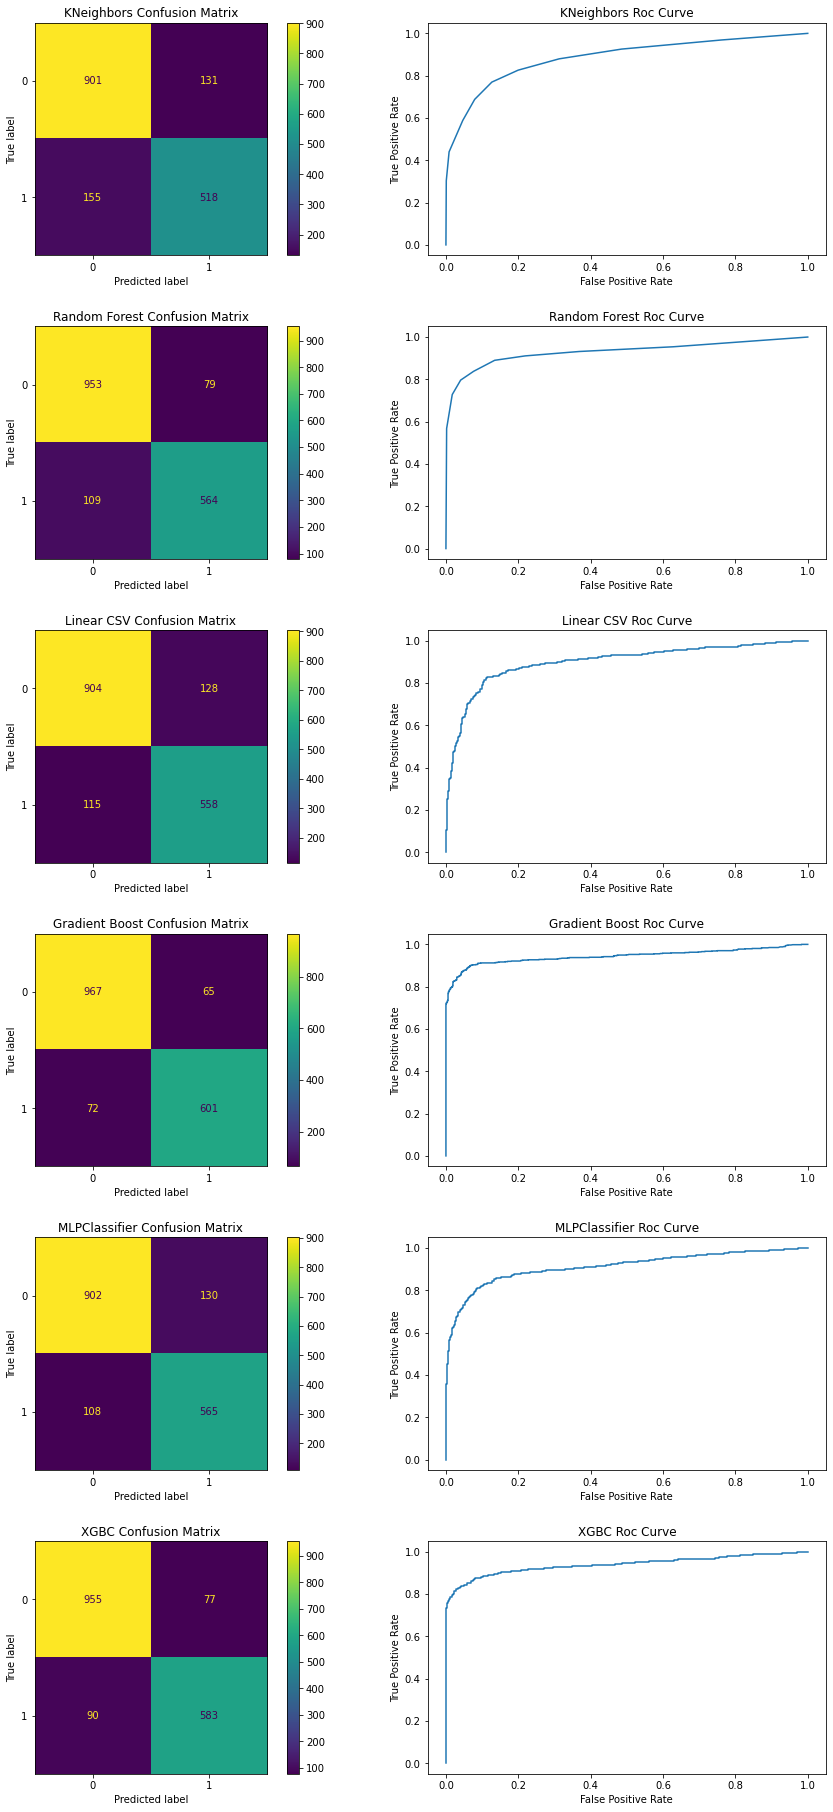

In [44]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import precision_recall_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Dict with the classifiers we are going to use
classifiers = {"KNeighbors": "KNeighborsClassifier", "Random Forest": "RandomForestClassifier",
              "Linear CSV": "LinearSVC", "MLP": "MLPClassifier",
               "Gradient Boost": "GradientBoostingClassifier", "XGBC": "XGBClassifier"}

# A dataframe to save the scores of each classifier
scores = pd.DataFrame(columns=["classifier","accuracy", "f1_score", "precision", "recall"])


# Create a function to evaluate the models
def evaluate_models(scores, X_train, y_train, y_test, classifier):
    """ With scores dataframe, data and the classifier the function
    return the dataframe with new metrics"""
    
    y_pred = classifier.predict(X_test)
    classifier_name = classifier.__class__.__name__
    
    
    if classifier_name == "LinearSVC":
        y_score = classifier.decision_function(X_test)
    else:
        y_score = classifier.predict_proba(X_test)
    
    
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    

                
    scores = scores.append({"classifier":classifier_name,
                  "accuracy": accuracy,
                  "f1_score": f1_score,
                  "precision": precision,
                  "recall": recall}, ignore_index=True)
    

    return y_pred, y_score, scores

    
print("\n\n========================================")
print("CONFUSION MATRIX AND ROC CURVES")
print("========================================\n \n")
fig, axes = plt.subplots(6,2 , figsize=(14,26))
fig.tight_layout(pad=5)
for key, value in classifiers.items():
    if value == "KNeighborsClassifier":        
        clf = KNeighborsClassifier(n_neighbors=9)
        clf.fit(X_train, y_train)
        
        
        y_pred, y_score, scores = evaluate_models(scores, X_train, y_train, y_test, clf)
        
        cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[0][0])
        plt.title('Confusion matrix of the classifier')
        fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[0][1])
        
        axes[0][0].set_title("{} Confusion Matrix".format(key))
        axes[0][1].set_title("{} Roc Curve".format(key))
        
    if value == "RandomForestClassifier":        
        forest = RandomForestClassifier(n_estimators=8, random_state=2)
        forest.fit(X_train, y_train)
        
        y_pred, y_score, scores = evaluate_models(scores, X_train, y_train, y_test, forest)
        
        cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[1][0])
        fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[1][1])
        
        axes[1][0].set_title("{} Confusion Matrix".format(key))
        axes[1][1].set_title("{} Roc Curve".format(key))

    
    if value == "LinearSVC":        
        linearCSV = LinearSVC(dual=False)
        linearCSV.fit(X_train, y_train)

        y_pred, y_score, scores = evaluate_models(scores, X_train, y_train, y_test, linearCSV)
        
        cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[2][0])
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[2][1])
        
        axes[2][0].set_title("{} Confusion Matrix".format(key))
        axes[2][1].set_title("{} Roc Curve".format(key))
    
    if value == "GradientBoostingClassifier":
        gbrt = GradientBoostingClassifier()
        gbrt.fit(X_train, y_train)
        
        y_pred, y_score, scores = evaluate_models(scores, X_train, y_train, y_test, gbrt)
        
        cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[3][0])
        fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[3][1])
        
        axes[3][0].set_title("{} Confusion Matrix".format(key))
        axes[3][1].set_title("{} Roc Curve".format(key))
    
    if value == "MLPClassifier":
        mlp = MLPClassifier(max_iter=2000, activation= 'tanh',
                    alpha= 0.0001, hidden_layer_sizes=(100,),
                    learning_rate='adaptive',
                    solver= 'adam')
        mlp.fit(X_train, y_train)
        
        y_pred, y_score, scores = evaluate_models(scores, X_train, y_train, y_test, mlp)
        
        cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[4][0])
        fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[4][1])
        
        axes[4][0].set_title("{} Confusion Matrix".format(value))
        axes[4][1].set_title("{} Roc Curve".format(value))
        
    
    if value == "XGBClassifier":
        xgbc = XGBClassifier(use_label_encoder=False, verbosity=0)
        xgbc.fit(X_train, y_train)

        y_pred, y_score, scores = evaluate_models(scores, X_train, y_train, y_test, xgbc)

        cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[5][0])
        fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[5][1])
        
        
        axes[5][0].set_title("{} Confusion Matrix".format(key))
        axes[5][1].set_title("{} Roc Curve".format(key))        

Confusion matrix and ROC curves points to GBC to be the best model. Let see the metrics

,classifier,accuracy,f1_score,precision,recall
0,KNeighborsClassifier,0.832258,0.783661,0.798151,0.769688
1,RandomForestClassifier,0.889736,0.857143,0.877138,0.838039
2,LinearSVC,0.857478,0.821192,0.813411,0.829123
3,MLPClassifier,0.860411,0.826023,0.812950,0.839525
4,GradientBoostingClassifier,0.919648,0.897685,0.902402,0.893016
5,XGBClassifier,0.902053,0.874719,0.883333,0.866270


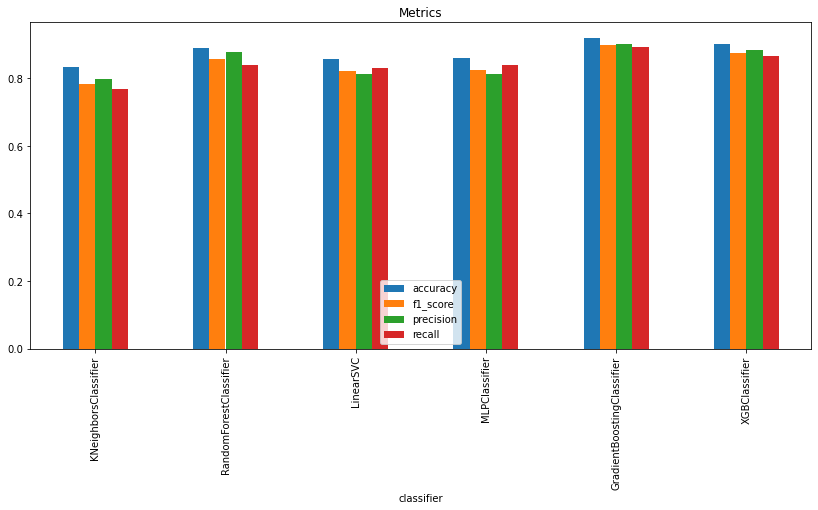

In [45]:
scores.plot(kind="bar", x="classifier",
            figsize=(14,6), title="Metrics");
scores

With all this data on the table we are going to choose GBC as our best classifier. 



In [56]:
model_filename = "Model/gcbmodel.sav"
dump(gbrt, open(model_filename, 'wb'))

# Gradient Boost Parameters

Let us now study the algorithm and analyze the parameters to see how they affect the results.

In [33]:
%%time
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D

all_train_results = []
all_test_results = []
parameters = []
parameters_values = []

# Learning Rate

learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

all_train_results.append(train_results)
all_test_results.append(test_results)
parameters.append("Learning rate")
parameters_values.append(learning_rates)
    
    
# N estimators

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100]
train_results = []
test_results = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(n_estimators=estimator)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    

all_train_results.append(train_results)
all_test_results.append(test_results)
parameters.append("N stimators")
parameters_values.append(n_estimators)

# Max depths

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   model = GradientBoostingClassifier(max_depth=max_depth)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
all_train_results.append(train_results)
all_test_results.append(test_results)
parameters.append("Max depths")
parameters_values.append(max_depths)


# Min samples splits

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   model = GradientBoostingClassifier(min_samples_split=min_samples_split)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
all_train_results.append(train_results)
all_test_results.append(test_results)
parameters.append("Min samples split")
parameters_values.append(min_samples_splits)


# Min samples leaf

min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    

all_train_results.append(train_results)
all_test_results.append(test_results)
parameters.append("Min samples leaf")
parameters_values.append(min_samples_leafs)


# Max features

max_features = list(range(1,features.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   model = GradientBoostingClassifier(max_features=max_feature)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

all_train_results.append(train_results)
all_test_results.append(test_results)
parameters.append("Max features")
parameters_values.append(max_features)

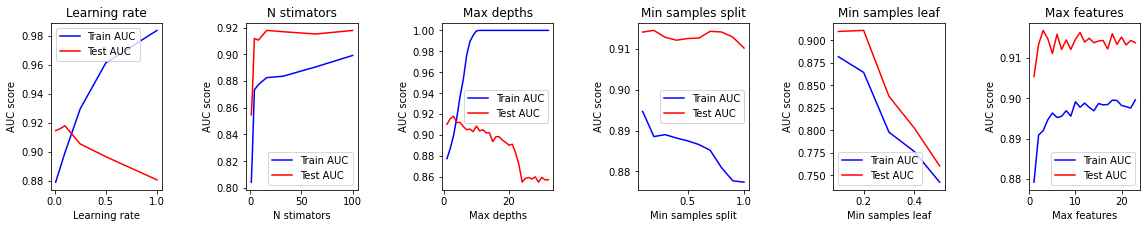

In [34]:
fig, axes = plt.subplots(1,6 , figsize=(17,4))
fig.tight_layout(pad=5)

for index, axe in enumerate(axes):
    axe.set_title(parameters[index])
    axe.plot(parameters_values[index], all_train_results[index], 'b', label='Train AUC')
    axe.plot(parameters_values[index], all_test_results[index], 'r', label='Test AUC')
    axe.legend()
    axe.set_ylabel('AUC score')
    axe.set_xlabel(parameters[index])
    

plt.show()

In [38]:
%%time
import multiprocessing
from sklearn.model_selection import RepeatedKFold


# Grid of hiperparameteres

param_grid = {'max_features'  : ['auto', 'sqrt', 'log2'],
              'max_depth'     : [None, 1, 3, 5, 10, 20],
              'subsample'     : [0.5, 1],
              'learning_rate' : [0.001, 0.01, 0.1],
              'n_estimators'  : [100, 250, 500]}

# Grid search CV

grid = GridSearchCV(estimator  = GradientBoostingClassifier(
                        random_state        = 123,
                        # Early stop detection
                        validation_fraction = 0.1,
                        n_iter_no_change    = 5,
                        tol                 = 0.0001),
                                    param_grid = param_grid,
                                    scoring    = 'neg_root_mean_squared_error',
                                    n_jobs     = multiprocessing.cpu_count() - 1,
                                    cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
                                    refit      = True,
                                    verbose    = 0,
                                    return_train_score = True)

grid.fit(X = X_train, y = y_train)

# Results

resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

CPU times: user 2.8 s, sys: 386 ms, total: 3.19 s
Wall time: 10min 33s


,param_learning_rate,param_max_depth,param_max_features,param_n_estimators,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
277,0.1,5,sqrt,100,1,-0.336889,0.014402,-0.265143,0.016352
279,0.1,5,sqrt,250,1,-0.336889,0.014402,-0.265143,0.016352
281,0.1,5,sqrt,500,1,-0.336889,0.014402,-0.265143,0.016352
163,0.01,5,auto,100,1,-0.336947,0.012972,-0.319554,0.006093


In [39]:
# Best parameters
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 1} : -0.3368890443396315 neg_root_mean_squared_error




METRICS FOR OPTIMIZED CLASSIFIER
Accuracy: 0.9207920792079208 
F1_score: 0.8934081346423564 
Precision: 0.8884239888423989 
Recall: 0.8984485190409027 
AUC: 0.9471919476856007 
 



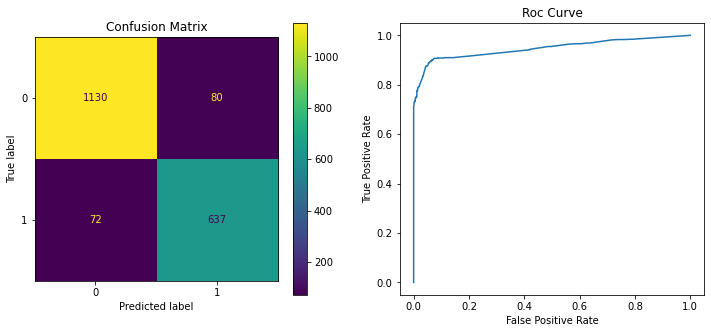

"{'learning_rate': 0.001, 'max_depth': 5, 'max_features': 'auto', 'subsample': 1}"

In [45]:
#We use the best parameters to optimize the Classifier

gbrt = GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                  min_samples_split=2).fit(X_train, y_train)
y_pred = gbrt.predict(X_test)
y_score = gbrt.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:, 1])

print("\n\n========================================")
print("METRICS FOR OPTIMIZED CLASSIFIER")
print("Accuracy: {} \nF1_score: {} \nPrecision: {} \nRecall: {} \nAUC: {} ".format(metrics.accuracy_score(y_test, y_pred),
                                                                           metrics.f1_score(y_test, y_pred),
                                                                           metrics.precision_score(y_test, y_pred),
                                                                           metrics.recall_score(y_test, y_pred),
                                                                           metrics.auc(fpr, tpr)))
print("========================================\n \n")

fig, axes = plt.subplots(1,2 , figsize=(12,5))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[0])
axes[0].set_title('Confusion Matrix')
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[1])
axes[1].set_title('Roc Curve')
plt.show()

"""{'learning_rate': 0.001, 'max_depth': 5, 'max_features': 'auto', 'subsample': 1}"""

In [44]:
%%time
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold

gbc = GradientBoostingClassifier()
parameters = {'learning_rate':[0.01, 0.05, 0.1, 0.5, 1], 
          'min_samples_split':[2,5,10,20], 
          'max_depth':[2,3,5,10]}

cv_test= KFold(n_splits=5)
clf = GridSearchCV(gbc, parameters,cv=cv_test)
clf.fit(X_train, y_train)

print(clf.best_params_)

{'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2}
CPU times: user 11min 38s, sys: 931 ms, total: 11min 39s
Wall time: 11min 39s


## Threshold adjustement
It is time to choose our decision threshold. In our case we prefer to keep the ones that are really positive, since we do not want to waste time analyzing machinery in good condition or that present failures in an incipient state. 


Accuracy: 0.9154046997389034 
F1_score: 0.8870292887029289 
Precision: 0.8724279835390947 
Recall: 0.902127659574468 
AUC: 0.9411312349803647 


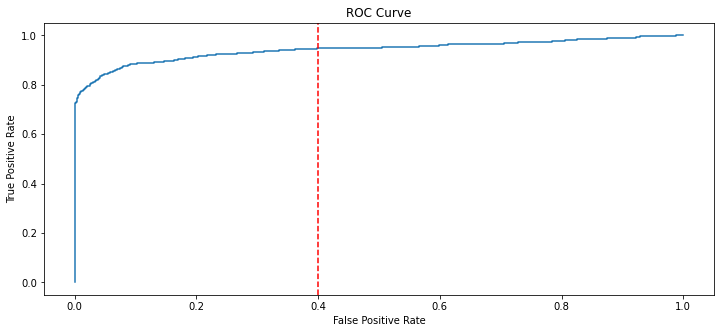

In [95]:
threshold = 0.4

y_pred = (gbrt.predict_proba(X_test)[:,1] >= threshold).astype(bool)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:, 1])

print("\n========================================")
print("Accuracy: {} \nF1_score: {} \nPrecision: {} \nRecall: {} \nAUC: {} ".format(metrics.accuracy_score(y_test, y_pred),
                                                                           metrics.f1_score(y_test, y_pred),
                                                                           metrics.precision_score(y_test, y_pred),
                                                                           metrics.recall_score(y_test, y_pred),
                                                                           metrics.auc(fpr, tpr)))
print("========================================")

fig, axes = plt.subplots(figsize=(8,8))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes)
plt.axvline(x=threshold, color='red', linestyle="--")
axes.set_title('ROC Curve')
plt.show()

In [58]:
#We have to get machines that have a point labeled with positive label.

merged_diagnostic_predict.loc[merged_diagnostic_predict.index > last_inspection, 'labeled'] = y_pred
result_positive = merged_diagnostic_predict[merged_diagnostic_predict.labeled == 1]
resultado = result_positive.machine.unique()
listado = []
for valor in resultado:
    if str(valor)[:2] == "S6":
        listado.append(valor)
print(listado)
print(len(listado))

['S6-67-M1', 'S6-67-M2', 'S6-68-M1', 'S6-68-M2', 'S6-69-M1', 'S6-73-M1', 'S6-73-M2', 'S6-74-M1', 'S6-74-M2', 'S6-75-M2', 'S6-76-M1', 'S6-76-M2', 'S6-77-M1', 'S6-77-M2', 'S6-78-M1', 'S6-78-M2', 'S6-79-M1', 'S6-79-M2', 'S6-63-M1', 'S6-62-M1', 'S6-61-M1', 'S6-60-M1']
22


In [59]:
by_points = result_positive.groupby(['machine', result_positive.point.str[:4]]).count()
by_points = by_points.drop(columns=['point'])
by_points = by_points[by_points['max_mms']>1]

In [60]:
resultado = by_points.reset_index().machine.unique()
listado = []
for valor in resultado:
    if str(valor)[:2] == "S6":
        listado.append(valor)
print(listado)
print(len(listado))

['S6-60-M1', 'S6-61-M1', 'S6-62-M1', 'S6-63-M1', 'S6-67-M1', 'S6-68-M1', 'S6-73-M1', 'S6-73-M2', 'S6-74-M1', 'S6-74-M2', 'S6-75-M2', 'S6-76-M1', 'S6-76-M2', 'S6-77-M1', 'S6-78-M1', 'S6-78-M2', 'S6-79-M1']
17


In [41]:
result_positive.to_csv('resultados.csv')

Now is time to save our results and upload to a file in Amazon's S3 service. After that we can check the result at:
<a href="https://projectargus.herokuapp.com/ma_results">Project Argus</a>

In [42]:
resultados = pd.read_csv('https://teromanager2.s3-us-west-2.amazonaws.com/projectargus/resultados.csv')

In [62]:
result_positive.groupby('machine').count()

,point,max_mms,rms_mms,max_acc,med_acc,rms_acc,kur_acc,cf_acc,num_peaks,a_range,b_range,c_range,d_range,e_range,f_range,g_range,h_range,i_range,j_range,max_dem,rms_dem,Nombre,diagnostico,Id_Estado_Activo,Id_Estado_Activo_fixed,prev_diag,pct_change_acc,mean_mms_prev,element_type,labeled
machine,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
S1-M19,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
S1-M20,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
S1-M21,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
S1-M23,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
S1-M24,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S6-77-M2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
S6-78-M1,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
S6-78-M2,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
